## 0. Imports

In [502]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
import pandas_ta as ta
import datetime
import itertools
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from xgboost import XGBRegressor, plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1. Read data into Dataframe

In [ ]:
df = pd.read_csv('../../long_short_local/raw_data/cleaned_data.csv')

In [682]:
df.head()

,Date,ALB_ZBRA,NRG_CPRT,DE_BXP,NRG_STE,NRG_XRAY,SO_NLOK,PEG_O
0,2020-08-31,0.311845,0.310544,2.548054,0.203834,0.727693,2.136432,0.882281
1,2020-09-01,0.332974,0.306303,2.687319,0.203522,0.722940,2.094566,0.855546
2,2020-09-02,0.332368,0.315056,2.629334,0.204743,0.734758,2.125291,0.872526
3,2020-09-03,0.339772,0.310060,2.534974,0.201707,0.728923,2.210971,0.848504
4,2020-09-04,0.356920,0.300754,2.536138,0.199887,0.707646,2.152835,0.854765


## 2. Prepare data

### 2.1 Add SMA (simple moving average) for 10, 20 and 60 days

In [683]:
# convert 'Date' column to datetime values
df['Date'] = pd.to_datetime(df['Date'].str[:10])

In [684]:
sma_list = [10, 20, 60]

for sma in sma_list:
    if sma == 10:
        sma_10_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma10 = pd.DataFrame(ta.sma(test_df[ratio], length=10))
            loop_df = pd.concat([test_df, sma10], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_10': f'{ratio}_SMA_10'}, inplace=True)
            sma_10_df_prep = pd.concat([sma_10_df_prep, loop_df], axis=1, ignore_index=False)
            sma_10_df = sma_10_df_prep.iloc[:, 3:]
    
    elif sma == 20:
        sma_20_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma20 = pd.DataFrame(ta.sma(test_df[ratio], length=20))
            loop_df = pd.concat([test_df, sma20], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_20': f'{ratio}_SMA_20'}, inplace=True)
            sma_20_df_prep = pd.concat([sma_20_df_prep, loop_df], axis=1, ignore_index=False)
            sma_20_df = sma_20_df_prep.iloc[:, 3:]
    
    else:
        sma_60_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma60 = pd.DataFrame(ta.sma(test_df[ratio], length=60))
            loop_df = pd.concat([test_df, sma60], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_60': f'{ratio}_SMA_60'}, inplace=True)
            sma_60_df_prep = pd.concat([sma_60_df_prep, loop_df], axis=1, ignore_index=False)
            sma_60_df = sma_60_df_prep.iloc[:, 3:]

### 2.2 Add RSI (relative strength index) for 14 days

In [685]:
rsi_14_df_prep = pd.DataFrame(df['Date'])

for ratio in df.columns:
    test_df = df[['Date', ratio]]
    rsi14 = pd.DataFrame(ta.rsi(test_df[ratio], length=14))
    loop_df = pd.concat([test_df, rsi14], axis=1, ignore_index=False)
    loop_df.rename(columns={'RSI_14': f'{ratio}_RSI_14'}, inplace=True)
    rsi_14_df_prep = pd.concat([rsi_14_df_prep, loop_df], axis=1, ignore_index=False)
    rsi_14_df = rsi_14_df_prep.iloc[:, 3:]

### 2.3 Concatenate all 4 DFs

In [686]:
sorted_df

,ALB_ZBRA,ALB_ZBRA_RSI_14,ALB_ZBRA_SMA_10,ALB_ZBRA_SMA_20,ALB_ZBRA_SMA_60,DE_BXP,DE_BXP_RSI_14,DE_BXP_SMA_10,DE_BXP_SMA_20,DE_BXP_SMA_60,...,PEG_O,PEG_O_RSI_14,PEG_O_SMA_10,PEG_O_SMA_20,PEG_O_SMA_60,SO_NLOK,SO_NLOK_RSI_14,SO_NLOK_SMA_10,SO_NLOK_SMA_20,SO_NLOK_SMA_60
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-31,0.311845,NaN,NaN,NaN,NaN,2.548054,NaN,NaN,NaN,NaN,...,0.882281,NaN,NaN,NaN,NaN,2.136432,NaN,NaN,NaN,NaN
2020-09-01,0.332974,NaN,NaN,NaN,NaN,2.687319,NaN,NaN,NaN,NaN,...,0.855546,NaN,NaN,NaN,NaN,2.094566,NaN,NaN,NaN,NaN
2020-09-02,0.332368,NaN,NaN,NaN,NaN,2.629334,NaN,NaN,NaN,NaN,...,0.872526,NaN,NaN,NaN,NaN,2.125291,NaN,NaN,NaN,NaN
2020-09-03,0.339772,NaN,NaN,NaN,NaN,2.534974,NaN,NaN,NaN,NaN,...,0.848504,NaN,NaN,NaN,NaN,2.210971,NaN,NaN,NaN,NaN
2020-09-04,0.356920,NaN,NaN,NaN,NaN,2.536138,NaN,NaN,NaN,NaN,...,0.854765,NaN,NaN,NaN,NaN,2.152835,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-15,0.813028,70.504616,0.762595,0.722713,0.722300,4.111073,81.464299,3.970735,3.794789,3.527865,...,0.920803,61.451740,0.900442,0.882573,0.927544,3.277218,63.210855,3.136534,3.047101,3.070884
2022-08-16,0.814154,70.669445,0.768577,0.729514,0.723594,4.118669,81.719008,4.004169,3.827520,3.538264,...,0.933379,65.711460,0.904288,0.885996,0.926260,3.283272,63.535067,3.159514,3.066469,3.074085
2022-08-17,0.815450,70.871029,0.776736,0.736559,0.725092,4.154118,82.900097,4.038913,3.859264,3.557522,...,0.935173,66.283816,0.907000,0.890162,0.925243,3.347435,66.867644,3.206335,3.090913,3.079466


In [687]:
concat_10_20_df = pd.concat([sma_10_df, sma_20_df], axis=1)
concat_10_20_60_df = pd.concat([concat_10_20_df, sma_60_df], axis=1)
combined_df = pd.concat([concat_10_20_60_df, rsi_14_df], axis=1)
# remove duplicates of 'Date' column
dropped_date_df = combined_df.loc[:,~combined_df.columns.duplicated()]
dropped_date_df.set_index('Date', inplace=True)
# sort the ratios by column name
sorted_df = dropped_date_df.reindex(sorted(dropped_date_df.columns, reverse=False), axis=1)

In [721]:
test_plot_df = sorted_df[['ALB_ZBRA', 'ALB_ZBRA_SMA_10', 'ALB_ZBRA_SMA_20', 'ALB_ZBRA_SMA_60']]

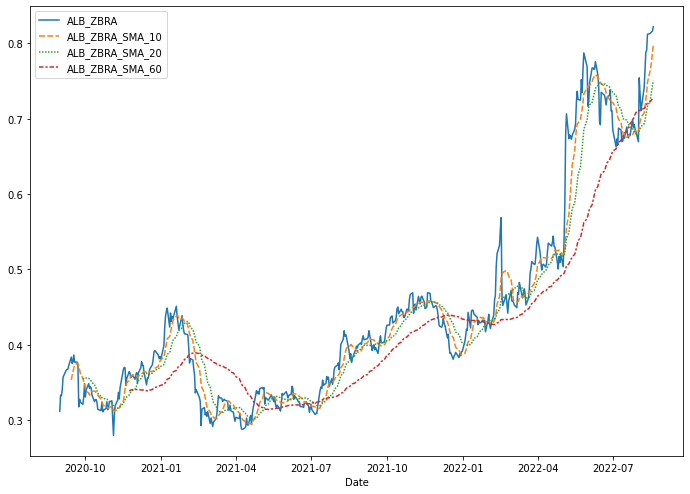

In [722]:
# test plot for the first ratio
dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
sns.lineplot(data=test_plot_df.iloc[:, :5]);

- sorted_df contains all ratios with SMA for 10, 20, 60 days and RSI for 14 days. 
- We will load each time series to the XGBoost model separately
- But first, we need to create the features and labels

# Model test

### Prophet - Start

In [817]:
# reset index => 'Date' column becomes normal column in preparation for Prophet
prophet_df = sorted_df

In [818]:
# add price features
# the new column contains the %age change of each day compared to the prior 5 days
prophet_df['5d_close_pct'] = prophet_df['ALB_ZBRA'].pct_change(5)

In [819]:
prophet_df['5d_future_close'] = prophet_df['ALB_ZBRA'].shift(-5)

In [820]:
prophet_df['5d_future_close_pct'] = prophet_df['5d_future_close'].pct_change(5)

In [821]:
# add datetime features and concatenate with ratio_df
days_of_week = pd.get_dummies(prophet_df.index.dayofweek, prefix='weekday', drop_first=True)
prophet_df = pd.concat([prophet_df.reset_index(), days_of_week], axis=1, ignore_index=False)

In [822]:
# select first ratio for testing
pr_first_ratio_df = prophet_df.iloc[:, :6]

In [823]:
# rename 'Date' and ratio column
pr_first_ratio_df = prophet_df.rename(columns={'5d_future_close': 'y', 'Date': 'ds'})

In [824]:
# fill NaNs
pr_first_ratio_df = pr_first_ratio_df.fillna(pr_first_ratio_df.median())

/var/folders/9c/wqkq2b6j16l2hg0gd5_m7sj00000gn/T/ipykernel_34565/722838502.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  pr_first_ratio_df = pr_first_ratio_df.fillna(pr_first_ratio_df.median())


In [825]:
pr_first_ratio_df.head()

,ds,ALB_ZBRA,ALB_ZBRA_RSI_14,ALB_ZBRA_SMA_10,ALB_ZBRA_SMA_20,ALB_ZBRA_SMA_60,DE_BXP,DE_BXP_RSI_14,DE_BXP_SMA_10,DE_BXP_SMA_20,...,SO_NLOK_SMA_10,SO_NLOK_SMA_20,SO_NLOK_SMA_60,5d_close_pct,y,5d_future_close_pct,weekday_1,weekday_2,weekday_3,weekday_4
0,2020-08-31,0.311845,53.506606,0.401902,0.40318,0.392237,2.548054,53.376443,3.24198,3.235732,...,2.629768,2.620719,2.571855,0.007214,0.366863,0.00683,0,0,0,0
1,2020-09-01,0.332974,53.506606,0.401902,0.40318,0.392237,2.687319,53.376443,3.24198,3.235732,...,2.629768,2.620719,2.571855,0.007214,0.367225,0.00683,1,0,0,0
2,2020-09-02,0.332368,53.506606,0.401902,0.40318,0.392237,2.629334,53.376443,3.24198,3.235732,...,2.629768,2.620719,2.571855,0.007214,0.368015,0.00683,0,1,0,0
3,2020-09-03,0.339772,53.506606,0.401902,0.40318,0.392237,2.534974,53.376443,3.24198,3.235732,...,2.629768,2.620719,2.571855,0.007214,0.372984,0.00683,0,0,1,0
4,2020-09-04,0.356920,53.506606,0.401902,0.40318,0.392237,2.536138,53.376443,3.24198,3.235732,...,2.629768,2.620719,2.571855,0.007214,0.383597,0.00683,0,0,0,1


In [826]:
# generate train and test sets
train_size = int(0.8 * pr_first_ratio_df.shape[0])
train_set_pr = pr_first_ratio_df[:train_size]
test_set_pr = pr_first_ratio_df[train_size:] 

#### Baseline model

In [827]:
y_true_base = pr_first_ratio_df['y']
y_pred_base = pr_first_ratio_df['y'].shift(5)

y_pred_base = y_pred_base.iloc[5:]
y_true_base = y_true_base.iloc[5:]

print(f'R2: {r2_score(y_true_base, y_pred_base)}')

R2: 0.8500034161665506


#### Prophet model

In [828]:
proph = Prophet(growth='linear', 
                yearly_seasonality=True,
                daily_seasonality=True)

proph.add_regressor('ALB_ZBRA_RSI_14')
proph.add_regressor('ALB_ZBRA_SMA_10')
proph.add_regressor('ALB_ZBRA_SMA_20')
proph.add_regressor('ALB_ZBRA_SMA_60')

proph.fit(train_set)

Initial log joint probability = -5.49779


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1157.77     0.0105107       368.116           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1161.59    0.00011319       66.8052      0.2249           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       1161.77   5.59797e-05       65.7641   7.347e-07       0.001      328  LS failed, Hessian reset 
     299       1161.83   9.76166e-05        122.54   1.093e-06       0.001      458  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     398       1161.86   6.37353e-08         65.42       0.866       0.866      582   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [829]:
# create df that holds future values
future_df = proph.make_future_dataframe(periods=len(test_set_pr),
                                        freq='D')

future_df.tail(1)

,ds
496,2022-07-06


In [830]:
# merge regressors
future_df = pd.concat([future_df,  pr_first_ratio_df.iloc[:, 2:]], axis=1)
future_df.head()

,ds,ALB_ZBRA_RSI_14,ALB_ZBRA_SMA_10,ALB_ZBRA_SMA_20,ALB_ZBRA_SMA_60,DE_BXP,DE_BXP_RSI_14,DE_BXP_SMA_10,DE_BXP_SMA_20,DE_BXP_SMA_60,...,SO_NLOK_SMA_10,SO_NLOK_SMA_20,SO_NLOK_SMA_60,5d_close_pct,y,5d_future_close_pct,weekday_1,weekday_2,weekday_3,weekday_4
0,2020-08-31,53.506606,0.401902,0.40318,0.392237,2.548054,53.376443,3.24198,3.235732,3.211952,...,2.629768,2.620719,2.571855,0.007214,0.366863,0.00683,0,0,0,0
1,2020-09-01,53.506606,0.401902,0.40318,0.392237,2.687319,53.376443,3.24198,3.235732,3.211952,...,2.629768,2.620719,2.571855,0.007214,0.367225,0.00683,1,0,0,0
2,2020-09-02,53.506606,0.401902,0.40318,0.392237,2.629334,53.376443,3.24198,3.235732,3.211952,...,2.629768,2.620719,2.571855,0.007214,0.368015,0.00683,0,1,0,0
3,2020-09-03,53.506606,0.401902,0.40318,0.392237,2.534974,53.376443,3.24198,3.235732,3.211952,...,2.629768,2.620719,2.571855,0.007214,0.372984,0.00683,0,0,1,0
4,2020-09-04,53.506606,0.401902,0.40318,0.392237,2.536138,53.376443,3.24198,3.235732,3.211952,...,2.629768,2.620719,2.571855,0.007214,0.383597,0.00683,0,0,0,1


In [771]:
# forecast
forecast = proph.predict(future_df)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,ALB_ZBRA_RSI_14,ALB_ZBRA_RSI_14_lower,ALB_ZBRA_RSI_14_upper,ALB_ZBRA_SMA_10,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
492,2022-07-02,0.549014,0.454719,0.504099,0.544312,0.553104,0.013543,0.013543,0.013543,0.126173,...,0.001877,0.001877,0.001877,-0.031916,-0.031916,-0.031916,0.0,0.0,0.0,0.479879
493,2022-07-03,0.549574,0.464406,0.508674,0.544809,0.553723,0.013666,0.013666,0.013666,0.128149,...,0.001877,0.001877,0.001877,-0.029833,-0.029833,-0.029833,0.0,0.0,0.0,0.485818
494,2022-07-04,0.550133,0.467456,0.512785,0.545282,0.554380,0.013815,0.013815,0.013815,0.130843,...,-0.000819,-0.000819,-0.000819,-0.027751,-0.027751,-0.027751,0.0,0.0,0.0,0.489720
495,2022-07-05,0.550693,0.473851,0.520329,0.545760,0.555015,0.013929,0.013929,0.013929,0.134339,...,-0.000892,-0.000892,-0.000892,-0.025697,-0.025697,-0.025697,0.0,0.0,0.0,0.496897
496,2022-07-06,0.551252,0.480184,0.527590,0.546241,0.555644,0.014671,0.014671,0.014671,0.137797,...,-0.001447,-0.001447,-0.001447,-0.023691,-0.023691,-0.023691,0.0,0.0,0.0,0.504539


In [772]:
proph_preds = forecast.yhat[train_size:].rename('prophet')

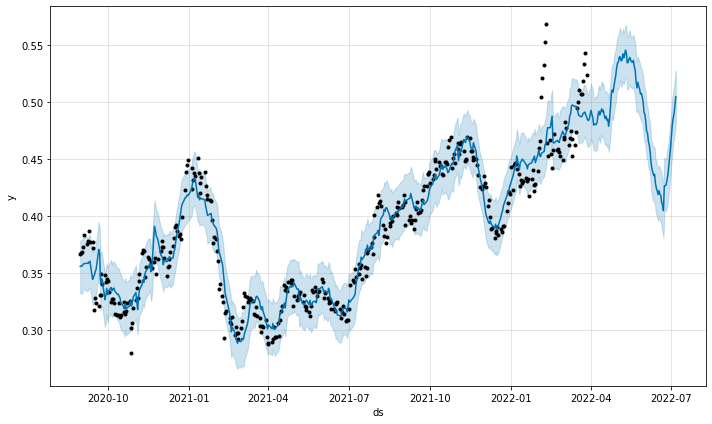

In [773]:
# visualise forecast
proph.plot(forecast);

In [774]:
# compute MAE and RMSE
print(round(mean_absolute_error(test_set['y'], proph_preds), 3))
print(round(mean_squared_error(test_set['y'], proph_preds), 3))

0.186
0.044


In [775]:
# compute MAPE
y_true, y_pred = np.array(test_set['y']), np.array(proph_preds)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [776]:
print(f'MAPE: {round(mape, 2)}')

MAPE: 26.37


In [777]:
# cross-validation
cv_df = cross_validation(proph,
                         horizon='20 days',
                         parallel='processes',
                         initial=20)

INFO:fbprophet:Making 56 forecasts with cutoffs between 2020-09-04 00:00:00 and 2022-03-08 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1500c3580>
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.



Initial log joint probability = -127.406
Iteration  1. Log joint probability =    9.96383. Improved by 137.37.

Initial log joint probability = -103.888
Iteration  2. Log joint probability =    13.2221. Improved by 3.2583.
Iteration  3. Log joint probability =     16.698. Improved by 3.47585.
Iteration  1. Log joint probability =    52.0817. Improved by 155.97.
Iteration  4. Log joint probability =    20.0873. Improved by 3.38931.
Iteration  2. Log joint probability =    71.7437. Improved by 19.6619.
Iteration  5. Log joint probability =    23.8347. Improved by 3.74746.

Initial log joint probability = -108.026
Iteration  3. Log joint probability =    86.8033. Improved by 15.0596.
Iteration  6. Log joint probability =     27.022. Improved by 3.18725.
Iteration  1. Log joint probability =     10.599. Improved by 118.625.
Iteration  7. Log joint probability =    30.7998. Improved by 3.77784.
Iteration  4. Log joint probability =    97.9097. Improved by 11.1064.
Iteration  8. Log joint p

INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.



Initial log joint probability = -116.349
Iteration 10. Log joint probability =    42.4466. Improved by 3.1013.
Iteration  8. Log joint probability =     106.24. Improved by 0.134733.
Iteration  4. Log joint probability =    98.0416. Improved by 0.230629.
Iteration  9. Log joint probability =    106.297. Improved by 0.0572838.
Iteration  1. Log joint probability =    22.4569. Improved by 138.806.
Iteration 10. Log joint probability =     106.37. Improved by 0.0728377.
Iteration 11. Log joint probability =    47.9718. Improved by 5.52521.
Iteration  5. Log joint probability =    98.1952. Improved by 0.15362.
Iteration 11. Log joint probability =    106.445. Improved by 0.0749584.
Iteration 12. Log joint probability =    50.2914. Improved by 2.31961.
Iteration 12. Log joint probability =    106.472. Improved by 0.0272044.
Iteration  2. Log joint probability =    35.3454. Improved by 12.8885.
Iteration 13. Log joint probability =    106.502. Improved by 0.0295744.

Initial log joint proba

INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Iteration  7. Log joint probability =     59.072. Improved by 0.23911.

Initial log joint probability = -122.791
Iteration 17. Log joint probability =    66.3781. Improved by 3.37852.
Iteration  1. Log joint probability =    36.2175. Improved by 158.182.
Iteration 23. Log joint probability =    106.844. Improved by 0.000490209.
Iteration  8. Log joint probability =    59.1121. Improved by 0.0401724.
Iteration  4. Log joint probability =    71.2859. Improved by 12.8451.
Iteration  1. Log joint probability =    16.3012. Improved by 139.092.
Iteration 24. Log joint probability =    106.844. Improved by 0.000394586.
Iteration  3. Log joint probability =    92.5151. Improved by 3.03902.
Iteration 10. Log joint probability =    116.573. Improved by 0.03816.
Iteration 25. Log joint probability =    106.845. Improved by 0.000905273.
Iteration  2. Log joint probability =     23.207. Improved by 6.9058.
Iteration 26. Log joint probability =    106.845. Improved by 0.000496362.
Iteration 11. Log 

Iteration  1. Log joint probability =    234.519. Improved by 560.296.
Initial log joint probability = -4.87423
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  2. Log joint probability =    434.408. Improved by 199.889.
      88       891.142   5.87909e-05       61.0517   1.405e-06       0.001      149  LS failed, Hessian reset 
      99       891.147   1.97758e-05       27.5944      0.7462      0.7462      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       891.148    2.5165e-06        27.564   1.161e-07       0.001      220  LS failed, Hessian reset 
     112       891.148   2.61441e-07       15.9834   1.829e-09       0.001      290  LS failed, Hessian reset 
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -332.313
Initial log joint probability = -5.02258
    Iter 

     121       916.137   2.03053e-05       30.3007   7.839e-07       0.001      339  LS failed, Hessian reset 
     160       916.141   4.10164e-06       38.5513   2.599e-07       0.001      438  LS failed, Hessian reset 
Iteration  4. Log joint probability =    737.907. Improved by 139.807.
Iteration  1. Log joint probability =    129.369. Improved by 461.682.
     161       916.141   1.85541e-06       15.4117   4.813e-08       0.001      480  LS failed, Hessian reset 
Initial log joint probability = -4.70134
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       916.141   1.85541e-06       15.4117   1.944e-08       0.001      541  LS failed, Hessian reset 
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -338.894
      60       952.471   9.20381e-05       39.6243   3.416e-06       0.001      114  LS failed, Hessian reset 
      9

In [778]:
# evaluation
mae = round(mean_absolute_error(cv_df['y'], cv_df['yhat']), 2)
print(f'MAE: {round(mae, 2)}')
rmse = round(mean_squared_error(cv_df['y'], cv_df['yhat']), 2)
print(f'RMSE: {round(rmse, 2)}')
y_true, y_pred = np.array(cv_df['y']), np.array(cv_df['yhat'])
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {round(mape, 2)}')

MAE: 0.69
RMSE: 5.43
MAPE: 195.25


In [779]:
# hyperparameter tuning
param_grid = {'seasonality_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1]
             }

grid = ParameterGrid(param_grid)

In [781]:
rmse = []

for params in grid:
    # build model
    proph = Prophet(growth='linear', 
                yearly_seasonality=True,
                daily_seasonality=True,
                seasonality_prior_scale = params['seasonality_prior_scale'],
                changepoint_prior_scale = params['changepoint_prior_scale'])

    proph.add_regressor('ALB_ZBRA_RSI_14')
    proph.add_regressor('ALB_ZBRA_SMA_10')
    proph.add_regressor('ALB_ZBRA_SMA_20')
    proph.add_regressor('ALB_ZBRA_SMA_60')

    proph.fit(train_set)
    # cross-val
    cv_df = cross_validation(proph,
                         horizon='20 days',
                         parallel='processes',
                         initial=20)
    
    # get results
    error = mean_squared_error(cv_df['y'], cv_df['yhat'])
    rmse.append(error)

INFO:fbprophet:Making 56 forecasts with cutoffs between 2020-09-04 00:00:00 and 2022-03-08 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x150e1ac70>


Initial log joint probability = -5.49779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       1128.37    0.00053855       415.853   1.257e-06       0.001      137  LS failed, Hessian reset 
      99       1128.56   9.48338e-07       292.744      0.6987     0.06987      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       1128.56   5.34253e-06       276.146   1.864e-08       0.001      218  LS failed, Hessian reset 
     124       1128.56   7.64707e-09       286.867      0.4702      0.1178      248   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.



Initial log joint probability = -87.958
Iteration  1. Log joint probability =    16.3106. Improved by 104.269.

Initial log joint probability = -99.0108
Iteration  2. Log joint probability =    23.3837. Improved by 7.07308.
Iteration  1. Log joint probability =    9.96925. Improved by 108.98.
Iteration  3. Log joint probability =    31.1369. Improved by 7.75316.
Iteration  2. Log joint probability =    13.1803. Improved by 3.21107.

Initial log joint probability = -41.6947
Iteration  3. Log joint probability =    16.6084. Improved by 3.4281.
Iteration  4. Log joint probability =    35.2804. Improved by 4.14353.
Iteration  1. Log joint probability =    53.3415. Improved by 95.0362.
Iteration  5. Log joint probability =    38.8187. Improved by 3.5383.
Iteration  2. Log joint probability =    76.7034. Improved by 23.3619.
Iteration  4. Log joint probability =    20.3636. Improved by 3.75519.

Initial log joint probability = -71.8593
Iteration  6. Log joint probability =    41.5828. Impro

INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


Iteration 27. Log joint probability =    106.477. Improved by 2.60329e-06.
Iteration  6. Log joint probability =    126.899. Improved by 13.1429.
Iteration 11. Log joint probability =    58.8556. Improved by 0.0179852.
Iteration 28. Log joint probability =    106.477. Improved by 1.46123e-05.
Iteration 14. Log joint probability =    60.7905. Improved by 3.06518.
Iteration 29. Log joint probability =    106.477. Improved by 6.66049e-06.
Iteration 17. Log joint probability =    67.1674. Improved by 0.558527.
Iteration 12. Log joint probability =    58.8643. Improved by 0.00869515.
Iteration 30. Log joint probability =    106.477. Improved by 6.30724e-07.
Iteration  4. Log joint probability =    139.726. Improved by 18.9348.
Iteration  4. Log joint probability =    76.3793. Improved by 12.2735.
Iteration  2. Log joint probability =    112.253. Improved by 75.7402.
Iteration 31. Log joint probability =    106.477. Improved by 3.95048e-06.
Iteration 13. Log joint probability =     58.873. I

INFO:fbprophet:Making 56 forecasts with cutoffs between 2020-09-04 00:00:00 and 2022-03-08 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x14f467520>


Initial log joint probability = -5.49779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1128.92   4.53929e-05       205.128           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       1128.93   1.96744e-06       275.688   6.364e-09       0.001      227  LS failed, Hessian reset 
     151       1128.93   7.51617e-09       280.711     0.05607      0.3653      259   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.



Initial log joint probability = -111.525
Iteration  1. Log joint probability =    16.3012. Improved by 127.826.
Iteration  2. Log joint probability =    23.1784. Improved by 6.87719.
Iteration  3. Log joint probability =    30.3083. Improved by 7.12986.
Iteration  4. Log joint probability =    36.6372. Improved by 6.32886.
Iteration  5. Log joint probability =    41.6252. Improved by 4.98802.

Initial log joint probability = -122.578
Iteration  6. Log joint probability =    48.7023. Improved by 7.07712.
Iteration  1. Log joint probability =    9.96383. Improved by 132.542.
Iteration  2. Log joint probability =    13.1731. Improved by 3.20925.
Iteration  7. Log joint probability =    51.3172. Improved by 2.61491.
Iteration  3. Log joint probability =    16.6735. Improved by 3.50037.

Initial log joint probability = -74.2832
Iteration  8. Log joint probability =    53.6406. Improved by 2.32336.
Iteration  9. Log joint probability =     61.852. Improved by 8.21139.
Iteration  4. Log join

INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


Iteration  1. Log joint probability =    22.4569. Improved by 117.883.
Iteration 12. Log joint probability =    51.3912. Improved by 3.00171.
Iteration  3. Log joint probability =    86.4151. Improved by 15.4527.
Iteration  8. Log joint probability =    150.483. Improved by 3.3947.

Initial log joint probability = -81.3801
Iteration  5. Log joint probability =    128.498. Improved by 11.2836.
Iteration  2. Log joint probability =    35.2391. Improved by 12.7822.
Iteration  6. Log joint probability =    130.193. Improved by 1.69456.
Iteration  5. Log joint probability =    172.466. Improved by 17.5632.
Iteration 13. Log joint probability =    51.4976. Improved by 0.106402.
Iteration 18. Log joint probability =     108.24. Improved by 0.0316792.
Iteration  7. Log joint probability =    132.292. Improved by 2.0993.
Iteration  6. Log joint probability =    175.138. Improved by 2.67155.
Iteration  1. Log joint probability =    36.2339. Improved by 117.614.
Iteration 14. Log joint probabilit

INFO:fbprophet:Making 56 forecasts with cutoffs between 2020-09-04 00:00:00 and 2022-03-08 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x14aa415b0>


Initial log joint probability = -5.49779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1128.85   2.51794e-06       243.463      0.7758      0.7758      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       1128.87   5.06691e-05       298.842   1.403e-07       0.001      177  LS failed, Hessian reset 
     199       1129.19   6.21476e-05       301.043       1.827      0.1827      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1129.21   5.67287e-06       269.728      0.3563      0.3563      422   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     319       1129.21   1.68917e-07       258.963      0.8491      0.8491      457   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.



Initial log joint probability = -135.092
Iteration  1. Log joint probability =    16.3006. Improved by 151.393.
Iteration  2. Log joint probability =    23.0922. Improved by 6.79165.
Iteration  3. Log joint probability =    31.1994. Improved by 8.10715.
Iteration  4. Log joint probability =    35.9678. Improved by 4.76848.
Iteration  5. Log joint probability =    43.9567. Improved by 7.98891.
Iteration  6. Log joint probability =    49.2521. Improved by 5.29531.
Iteration  7. Log joint probability =    57.3982. Improved by 8.14614.
Iteration  8. Log joint probability =    60.7415. Improved by 3.34333.
Iteration  9. Log joint probability =    69.4116. Improved by 8.67006.

Initial log joint probability = -88.8287
Iteration 10. Log joint probability =    73.2948. Improved by 3.88324.

Initial log joint probability = -105.296
Iteration  1. Log joint probability =    51.1056. Improved by 139.934.
Iteration 11. Log joint probability =    87.6449. Improved by 14.3501.
Iteration  2. Log join

INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Iteration  4. Log joint probability =    168.871. Improved by 26.3637.
Iteration  1. Log joint probability =    8.73959. Improved by 100.097.

Initial log joint probability = -118.993
Iteration  8. Log joint probability =    106.774. Improved by 0.322548.
Iteration  3. Log joint probability =    62.1558. Improved by 11.904.
Iteration 16. Log joint probability =    99.0311. Improved by 0.786743.
Iteration  2. Log joint probability =    10.3234. Improved by 1.58377.
Iteration  9. Log joint probability =    106.886. Improved by 0.112043.
Iteration  5. Log joint probability =    177.769. Improved by 8.89778.
Iteration  1. Log joint probability =    22.4367. Improved by 141.43.
Iteration  6. Log joint probability =    177.918. Improved by 0.149252.
Iteration 17. Log joint probability =    99.7737. Improved by 0.742567.
Iteration  4. Log joint probability =    74.1582. Improved by 12.0023.
Iteration 10. Log joint probability =    106.926. Improved by 0.0396982.
Iteration  7. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


Iteration 14. Log joint probability =    61.5437. Improved by 0.00411344.
Iteration  8. Log joint probability =     132.57. Improved by 2.86134.
Iteration 15. Log joint probability =     61.546. Improved by 0.00233806.
Iteration 19. Log joint probability =    178.522. Improved by 0.00110642.
Iteration 16. Log joint probability =    61.5478. Improved by 0.0018256.
Iteration  5. Log joint probability =     23.593. Improved by 3.5579.
Iteration 17. Log joint probability =    61.5479. Improved by 0.000116838.
Iteration 23. Log joint probability =    107.043. Improved by 0.0171592.
Iteration 18. Log joint probability =     61.549. Improved by 0.00103933.
Iteration 12. Log joint probability =      80.07. Improved by 0.00527843.
Iteration 19. Log joint probability =    61.5494. Improved by 0.000463241.
Iteration 20. Log joint probability =    178.526. Improved by 0.00401158.
Iteration 20. Log joint probability =    61.5495. Improved by 1.32399e-05.
Iteration 21. Log joint probability =    61.

INFO:fbprophet:Making 56 forecasts with cutoffs between 2020-09-04 00:00:00 and 2022-03-08 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x14eadd730>


Initial log joint probability = -5.49779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1158.02     0.0049845       243.339           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       1161.34    0.00011932       134.621   9.588e-07       0.001      249  LS failed, Hessian reset 
     199       1161.57   7.10919e-05          63.6     0.07299           1      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       1161.71   0.000151111       180.918   1.904e-06       0.001      358  LS failed, Hessian reset 
     299       1161.77   0.000401354       72.5986           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       1161.83   0.000220551       72.9486    2.48e-06       0.001      492  LS failed, Hessian rese

INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


Iteration 11. Log joint probability =    79.9297. Improved by 0.0281882.
Iteration  2. Log joint probability =    13.2294. Improved by 3.26012.
Iteration  6. Log joint probability =    58.7477. Improved by 0.172086.
Iteration 12. Log joint probability =    79.9384. Improved by 0.00871328.
Iteration 18. Log joint probability =     118.84. Improved by 0.22563.
Iteration  7. Log joint probability =    58.8355. Improved by 0.0877925.
Iteration 13. Log joint probability =    79.9451. Improved by 0.00669582.
Iteration  8. Log joint probability =    58.8398. Improved by 0.00422701.
Iteration 19. Log joint probability =    118.865. Improved by 0.0245412.
Iteration  9. Log joint probability =    58.8703. Improved by 0.030504.
Iteration 14. Log joint probability =    79.9499. Improved by 0.00487769.

Initial log joint probability = -90.9521
Iteration 10. Log joint probability =    58.8742. Improved by 0.00398039.
Iteration 15. Log joint probability =    79.9512. Improved by 0.0012819.
Iteration 

INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


Iteration 42. Log joint probability =    79.9598. Improved by 5.12753e-08.
Iteration 31. Log joint probability =    130.947. Improved by 0.0179201.
Iteration 32. Log joint probability =    130.948. Improved by 0.0012147.
Iteration 11. Log joint probability =    54.7784. Improved by 0.00612316.
Iteration 43. Log joint probability =    79.9598. Improved by 2.69041e-08.
Iteration  3. Log joint probability =    143.832. Improved by 30.7609.
Iteration  7. Log joint probability =    148.906. Improved by 0.129749.
Iteration 33. Log joint probability =    130.959. Improved by 0.0111534.
Iteration  4. Log joint probability =    105.451. Improved by 12.3429.
Iteration 44. Log joint probability =    79.9598. Improved by 6.76403e-09.
Iteration  8. Log joint probability =    148.939. Improved by 0.033084.
Iteration  9. Log joint probability =    41.4971. Improved by 8.6756.
Iteration 34. Log joint probability =    130.967. Improved by 0.00820619.
Iteration 35. Log joint probability =    130.972. Im

Iteration  2. Log joint probability =    434.799. Improved by 200.188.
Iteration  2. Log joint probability =    518.361. Improved by 389.523.
Iteration  3. Log joint probability =    598.613. Improved by 163.815.
Initial log joint probability = -5.02258
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  3. Log joint probability =    518.403. Improved by 0.0420448.
      89       916.106   5.43654e-05       52.9227   1.632e-06       0.001      164  LS failed, Hessian reset 
      99       916.109   3.41569e-05        30.118           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       916.128   0.000114432        103.29   1.749e-06       0.001      244  LS failed, Hessian reset 
     134       916.132   1.60768e-05       31.4803   7.285e-07       0.001      294  LS failed, Hessian reset 
Iteration  4. Log joint probability =     769.15. Improved by 170.537

INFO:fbprophet:Making 56 forecasts with cutoffs between 2020-09-04 00:00:00 and 2022-03-08 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1510d75e0>


Initial log joint probability = -5.49779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1157.77     0.0105107       368.116           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1161.59    0.00011319       66.8052      0.2249           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       1161.77   5.59797e-05       65.7641   7.347e-07       0.001      328  LS failed, Hessian reset 
     299       1161.83   9.76166e-05        122.54   1.093e-06       0.001      458  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     398       1161.86   6.37353e-08         65.42       0.866       0.866      582   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.



Initial log joint probability = -127.406
Iteration  1. Log joint probability =    9.96383. Improved by 137.37.
Iteration  2. Log joint probability =    13.2221. Improved by 3.2583.
Iteration  3. Log joint probability =     16.698. Improved by 3.47585.

Initial log joint probability = -110.35
Iteration  4. Log joint probability =    20.0873. Improved by 3.38931.
Iteration  1. Log joint probability =    36.2339. Improved by 146.584.
Iteration  5. Log joint probability =    23.8347. Improved by 3.74746.
Iteration  2. Log joint probability =    50.8661. Improved by 14.6322.

Initial log joint probability = -103.888
Iteration  6. Log joint probability =     27.022. Improved by 3.18725.
Iteration  3. Log joint probability =    58.4408. Improved by 7.57471.
Iteration  7. Log joint probability =    30.7998. Improved by 3.77784.
Iteration  4. Log joint probability =    71.2859. Improved by 12.8451.
Iteration  1. Log joint probability =    52.0817. Improved by 155.97.
Iteration  8. Log joint pr

INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.



Initial log joint probability = -122.791
Iteration  9. Log joint probability =    39.3453. Improved by 5.46114.
Iteration  7. Log joint probability =    79.4579. Improved by 0.265513.
Iteration  3. Log joint probability =    86.8033. Improved by 15.0596.
Iteration  8. Log joint probability =    79.5018. Improved by 0.0439092.
Iteration 10. Log joint probability =    42.4466. Improved by 3.1013.
Iteration  1. Log joint probability =    16.3012. Improved by 139.092.
Iteration  9. Log joint probability =    79.5663. Improved by 0.0644977.
Iteration 10. Log joint probability =     79.648. Improved by 0.081717.

Initial log joint probability = -121.965
Iteration 11. Log joint probability =    79.7376. Improved by 0.0895726.
Iteration  4. Log joint probability =    97.9097. Improved by 11.1064.
Iteration  2. Log joint probability =     23.207. Improved by 6.9058.
Iteration 11. Log joint probability =    47.9718. Improved by 5.52521.
Iteration 12. Log joint probability =    79.9654. Improved

Iteration  2. Log joint probability =    434.408. Improved by 199.889.
Iteration  3. Log joint probability =      598.1. Improved by 163.692.
Initial log joint probability = -4.87423
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       891.142   5.87909e-05       61.0517   1.405e-06       0.001      149  LS failed, Hessian reset 
      99       891.147   1.97758e-05       27.5944      0.7462      0.7462      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       891.148    2.5165e-06        27.564   1.161e-07       0.001      220  LS failed, Hessian reset 
     112       891.148   2.61441e-07       15.9834   1.829e-09       0.001      290  LS failed, Hessian reset 
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -332.313
Iteration  4. Log joint probability =    737.907. 

      54       916.086    2.0901e-05        42.683   8.451e-07       0.001      108  LS failed, Hessian reset 
Iteration  5. Log joint probability =    844.841. Improved by 106.934.
      70       916.106   0.000152302        77.771   2.599e-06       0.001      168  LS failed, Hessian reset 
      75       916.109   1.36961e-05       21.9978   4.538e-07       0.001      210  LS failed, Hessian reset 
      99       916.112   3.64245e-05       47.0235     0.07389           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  1. Log joint probability =    129.369. Improved by 461.682.
     121       916.137   2.03053e-05       30.3007   7.839e-07       0.001      339  LS failed, Hessian reset 
Initial log joint probability = -4.70134
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  6. Log joint probability =    868.788. Improved by 23.9469.
     160       916.141   4.1016

INFO:fbprophet:Making 56 forecasts with cutoffs between 2020-09-04 00:00:00 and 2022-03-08 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x150b9e7c0>


Initial log joint probability = -5.49779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1157.66    0.00402324       325.689           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       1161.33   0.000110383       136.016   4.837e-07       0.001      228  LS failed, Hessian reset 
     199       1161.61    0.00117985       93.1222           1           1      273   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       1161.68   0.000152473        135.53   1.756e-06       0.001      320  LS failed, Hessian reset 
     288       1161.83   2.67405e-05       77.3492   3.986e-07       0.001      456  LS failed, Hessian reset 
     299       1161.83   3.73762e-05       67.9359           1           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.



Initial log joint probability = -127.455
Iteration  1. Log joint probability =    51.1056. Improved by 178.561.
Iteration  2. Log joint probability =    65.7565. Improved by 14.6509.

Initial log joint probability = -150.973
Iteration  3. Log joint probability =    73.4118. Improved by 7.65526.
Iteration  1. Log joint probability =    9.96306. Improved by 160.936.
Iteration  4. Log joint probability =    92.3405. Improved by 18.9288.
Iteration  2. Log joint probability =    13.2211. Improved by 3.25806.

Initial log joint probability = -133.917
Iteration  3. Log joint probability =    16.7075. Improved by 3.48639.
Iteration  5. Log joint probability =    101.537. Improved by 9.19667.
Iteration  6. Log joint probability =    105.941. Improved by 4.40417.
Iteration  1. Log joint probability =    36.1539. Improved by 170.071.
Iteration  7. Log joint probability =    106.277. Improved by 0.335455.
Iteration  4. Log joint probability =    20.0351. Improved by 3.32761.
Iteration  8. Log joi

INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Iteration 31. Log joint probability =      107.1. Improved by 0.000334694.
Iteration 15. Log joint probability =    61.5466. Improved by 0.000392554.
Iteration  6. Log joint probability =    50.1375. Improved by 4.37605.
Iteration 32. Log joint probability =    107.101. Improved by 0.000552772.
Iteration 33. Log joint probability =    107.101. Improved by 0.000135445.
Iteration  3. Log joint probability =    92.6315. Improved by 80.7028.
Iteration 34. Log joint probability =    107.102. Improved by 0.000389548.
Iteration 16. Log joint probability =     61.547. Improved by 0.000392276.
Iteration 35. Log joint probability =    107.102. Improved by 0.000137577.
Iteration 17. Log joint probability =    61.5483. Improved by 0.0012777.
Iteration 13. Log joint probability =    59.0145. Improved by 12.1027.
Iteration 14. Log joint probability =    80.1204. Improved by 0.00476311.
Iteration 18. Log joint probability =    61.5483. Improved by 4.87394e-06.
Iteration 19. Log joint probability =   

Iteration  2. Log joint probability =    518.231. Improved by 388.736.
Initial log joint probability = -5.02258
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.70134
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  3. Log joint probability =    518.266. Improved by 0.034767.
      80        916.08   3.20279e-05       45.8617   6.771e-07       0.001      148  LS failed, Hessian reset 
      99       916.095   0.000182861       59.5317      0.4843      0.4843      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79        952.61   7.75441e-05       80.2748   1.142e-06       0.001      138  LS failed, Hessian reset 
      99       952.662   6.92112e-05       31.2587      0.8823      0.8823      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119   

INFO:fbprophet:Making 56 forecasts with cutoffs between 2020-09-04 00:00:00 and 2022-03-08 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x150b50520>


Initial log joint probability = -5.49779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1164.45     0.0021643       185.222      0.3515           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1167.16   0.000576614       53.9109      0.4634      0.4634      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1167.68    0.00162161       53.1514           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       1167.77   6.89475e-05        67.005   4.063e-07       0.001      409  LS failed, Hessian reset 
     399       1167.92   0.000318394       40.5167           1           1      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       1167.93   1.12982e-07    

INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.



Initial log joint probability = -105.919
Iteration  1. Log joint probability =    9.96925. Improved by 115.888.

Initial log joint probability = -101.793
Iteration  2. Log joint probability =    13.2355. Improved by 3.26625.
Iteration  1. Log joint probability =    22.5148. Improved by 124.308.
Iteration  3. Log joint probability =     16.636. Improved by 3.40051.
Iteration  2. Log joint probability =    35.5037. Improved by 12.9889.
Iteration  4. Log joint probability =    20.3636. Improved by 3.7276.
Iteration  3. Log joint probability =    46.6044. Improved by 11.1007.

Initial log joint probability = -99.2596
Iteration  5. Log joint probability =    23.5838. Improved by 3.22023.
Iteration  4. Log joint probability =      55.34. Improved by 8.73566.
Iteration  1. Log joint probability =    36.4417. Improved by 135.701.
Iteration  6. Log joint probability =    25.8699. Improved by 2.28604.
Iteration  5. Log joint probability =     55.344. Improved by 0.00394081.

Initial log joint p

INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


Iteration 27. Log joint probability =    58.8863. Improved by 5.40366e-05.

Initial log joint probability = -115.726
Iteration 28. Log joint probability =    58.8864. Improved by 2.13479e-05.
Iteration 18. Log joint probability =    79.9521. Improved by 0.00036205.
Iteration 29. Log joint probability =    58.8864. Improved by 2.23875e-05.
Iteration  4. Log joint probability =    104.649. Improved by 0.0455133.
Iteration 30. Log joint probability =    58.8864. Improved by 1.49638e-05.
Iteration  5. Log joint probability =    106.328. Improved by 0.756062.
Iteration 31. Log joint probability =    58.8864. Improved by 2.80541e-05.
Iteration 19. Log joint probability =    79.9529. Improved by 0.000838957.
Iteration 32. Log joint probability =    58.8864. Improved by 6.46062e-06.
Iteration 13. Log joint probability =    54.6115. Improved by 2.84138.
Iteration 20. Log joint probability =    79.9533. Improved by 0.000363272.
Iteration 33. Log joint probability =    58.8864. Improved by 8.1496

INFO:fbprophet:Making 56 forecasts with cutoffs between 2020-09-04 00:00:00 and 2022-03-08 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x14fa274c0>


Initial log joint probability = -5.49779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1164.23    0.00367272       181.313           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1166.99    0.00365564        136.47           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       1167.29   0.000220752       177.192   2.415e-06       0.001      300  LS failed, Hessian reset 
     298       1167.61   0.000213876       77.2249   3.327e-06       0.001      457  LS failed, Hessian reset 
     299       1167.61   0.000119098       52.3108           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     388        1167.9   5.39629e-05       53.5804   1.132e-06       0.001      611  LS failed, Hessian rese

INFO:fbprophet:n_changepoints greater than number of observations. Using 24.



Initial log joint probability = -120.524
Iteration  1. Log joint probability =    52.0817. Improved by 172.605.
Iteration  2. Log joint probability =    71.8375. Improved by 19.7558.
Iteration  3. Log joint probability =    86.8472. Improved by 15.0097.
Iteration  4. Log joint probability =    97.9472. Improved by 11.1.
Iteration  5. Log joint probability =    103.439. Improved by 5.49177.
Iteration  6. Log joint probability =    106.074. Improved by 2.63525.
Iteration  7. Log joint probability =    106.457. Improved by 0.382527.
Iteration  8. Log joint probability =    106.466. Improved by 0.0096724.
Iteration  9. Log joint probability =     106.47. Improved by 0.00341922.
Iteration 10. Log joint probability =    106.593. Improved by 0.122787.
Iteration 11. Log joint probability =    106.629. Improved by 0.0365738.
Iteration 12. Log joint probability =    106.651. Improved by 0.0216096.
Iteration 13. Log joint probability =    106.695. Improved by 0.0438621.
Iteration 14. Log joint p

INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


Iteration 33. Log joint probability =    106.846. Improved by 3.1849e-05.
Iteration  3. Log joint probability =     16.701. Improved by 3.47279.
Iteration 34. Log joint probability =    106.846. Improved by 6.29731e-05.
Iteration  7. Log joint probability =    59.2121. Improved by 0.174551.
Iteration 35. Log joint probability =    106.847. Improved by 3.33485e-05.
Iteration  8. Log joint probability =    59.3225. Improved by 0.11042.
Iteration 36. Log joint probability =    106.847. Improved by 3.81236e-05.
Iteration  4. Log joint probability =    20.0873. Improved by 3.38625.
Iteration  1. Log joint probability =     10.599. Improved by 135.954.

Initial log joint probability = -131.848
Iteration 37. Log joint probability =    106.847. Improved by 7.4233e-06.
Iteration 38. Log joint probability =    106.847. Improved by 1.74907e-05.
Iteration  9. Log joint probability =    59.3613. Improved by 0.0387616.
Iteration 39. Log joint probability =    106.847. Improved by 5.70176e-06.
Iterat

INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


Iteration 33. Log joint probability =    59.5732. Improved by 0.000444616.
Iteration 55. Log joint probability =    106.847. Improved by 5.75932e-08.
Iteration 34. Log joint probability =    59.5734. Improved by 0.000240841.
Iteration  6. Log joint probability =    98.5443. Improved by 0.142778.

Initial log joint probability = -139.293
Iteration 35. Log joint probability =    59.5735. Improved by 0.000139408.
Iteration 56. Log joint probability =    106.847. Improved by 1.93007e-08.
Iteration 10. Log joint probability =    42.4447. Improved by 3.1162.
Iteration 57. Log joint probability =    106.847. Improved by 3.432e-08.
Iteration  1. Log joint probability =    36.2339. Improved by 159.061.
Iteration 36. Log joint probability =    59.5737. Improved by 0.00013299.
Iteration  3. Log joint probability =    30.3243. Improved by 7.11367.
Iteration 37. Log joint probability =    59.5737. Improved by 4.14922e-05.
Iteration 58. Log joint probability =    106.847. Improved by 7.82399e-09.
It

INFO:fbprophet:Making 56 forecasts with cutoffs between 2020-09-04 00:00:00 and 2022-03-08 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x14fa3adc0>


Initial log joint probability = -5.49779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1164.19    0.00163361       130.257           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1167.22   0.000102365       53.9027      0.9199      0.9199      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     287       1167.65   9.88314e-05       139.171   6.504e-07       0.001      367  LS failed, Hessian reset 
     299       1167.76   0.000254347       82.6606           1           1      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     372        1167.9   0.000240302       129.516   4.366e-06       0.001      501  LS failed, Hessian reset 
     399       1167.92   8.58997e-06       28.1409           1           1      536   
    Iter      log pro

INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.



Initial log joint probability = -148.927
Iteration  1. Log joint probability =    22.4367. Improved by 171.364.
Iteration  2. Log joint probability =    35.2948. Improved by 12.8581.
Iteration  3. Log joint probability =    46.2362. Improved by 10.9413.
Iteration  4. Log joint probability =    54.7361. Improved by 8.49998.
Iteration  5. Log joint probability =    60.3011. Improved by 5.56498.

Initial log joint probability = -153.053
Iteration  6. Log joint probability =     61.452. Improved by 1.15086.
Iteration  7. Log joint probability =    61.4817. Improved by 0.0297326.
Iteration  8. Log joint probability =    61.5084. Improved by 0.0266919.
Iteration  9. Log joint probability =      61.52. Improved by 0.0115663.
Iteration 10. Log joint probability =    61.5209. Improved by 0.000904425.
Iteration 11. Log joint probability =    61.5214. Improved by 0.000521577.
Iteration 12. Log joint probability =    61.5341. Improved by 0.012669.
Iteration 13. Log joint probability =    61.5386.

INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


Iteration  8. Log joint probability =    31.0719. Improved by 1.7644.
Iteration 50. Log joint probability =      61.55. Improved by 5.46084e-08.
Iteration 51. Log joint probability =      61.55. Improved by 4.00858e-08.
Iteration 52. Log joint probability =      61.55. Improved by 2.42699e-09.

Initial log joint probability = -162.86
Iteration  4. Log joint probability =    92.3934. Improved by 18.9991.
Iteration  9. Log joint probability =    35.2614. Improved by 4.18948.
Iteration  3. Log joint probability =    31.9824. Improved by 15.6419.
Iteration  7. Log joint probability =    93.4212. Improved by 0.0693044.

Initial log joint probability = -146.394
Iteration  1. Log joint probability =    35.7168. Improved by 198.577.
Iteration  5. Log joint probability =    101.589. Improved by 9.19523.
Iteration 10. Log joint probability =    38.3559. Improved by 3.09458.
Iteration  6. Log joint probability =    106.285. Improved by 4.69583.
Iteration  4. Log joint probability =    37.4327. Im

In [782]:
# best parameters
best_params = grid[np.argmin(rmse)]
print(best_params)

{'seasonality_prior_scale': 10, 'changepoint_prior_scale': 0.05}


In [783]:
# final model
proph = Prophet(growth='linear', 
            yearly_seasonality=True,
            daily_seasonality=True,
            seasonality_prior_scale = best_params['seasonality_prior_scale'],
            changepoint_prior_scale = best_params['changepoint_prior_scale'])

proph.add_regressor('ALB_ZBRA_RSI_14')
proph.add_regressor('ALB_ZBRA_SMA_10')
proph.add_regressor('ALB_ZBRA_SMA_20')
proph.add_regressor('ALB_ZBRA_SMA_60')

proph.fit(train_set)

Initial log joint probability = -5.49779


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1157.77     0.0105107       368.116           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1161.59    0.00011319       66.8052      0.2249           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       1161.77   5.59797e-05       65.7641   7.347e-07       0.001      328  LS failed, Hessian reset 
     299       1161.83   9.76166e-05        122.54   1.093e-06       0.001      458  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     398       1161.86   6.37353e-08         65.42       0.866       0.866      582   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [813]:
# create future dataframe
future_df = proph.make_future_dataframe(periods=len(test_set),
                                        freq='D')
# merge regressors
#future_df = pd.concat([future_df,  pr_first_ratio_df.iloc[:, 2:]], axis=1)
#future_df.head()
#future_df.tail(1)

In [814]:
future_df.shape

(497, 1)

In [816]:
len(test_set)

100

In [785]:
# forecast
forecast = proph.predict(future_df)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,ALB_ZBRA_RSI_14,ALB_ZBRA_RSI_14_lower,ALB_ZBRA_RSI_14_upper,ALB_ZBRA_SMA_10,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
492,2022-07-02,0.549014,0.455743,0.503878,0.545175,0.553021,0.013543,0.013543,0.013543,0.126173,...,0.001877,0.001877,0.001877,-0.031916,-0.031916,-0.031916,0.0,0.0,0.0,0.479879
493,2022-07-03,0.549574,0.462305,0.508372,0.545690,0.553651,0.013666,0.013666,0.013666,0.128149,...,0.001877,0.001877,0.001877,-0.029833,-0.029833,-0.029833,0.0,0.0,0.0,0.485818
494,2022-07-04,0.550133,0.466275,0.514278,0.546171,0.554275,0.013815,0.013815,0.013815,0.130843,...,-0.000819,-0.000819,-0.000819,-0.027751,-0.027751,-0.027751,0.0,0.0,0.0,0.489720
495,2022-07-05,0.550693,0.472547,0.519543,0.546642,0.554887,0.013929,0.013929,0.013929,0.134339,...,-0.000892,-0.000892,-0.000892,-0.025697,-0.025697,-0.025697,0.0,0.0,0.0,0.496897
496,2022-07-06,0.551252,0.480276,0.528622,0.547118,0.555499,0.014671,0.014671,0.014671,0.137797,...,-0.001447,-0.001447,-0.001447,-0.023691,-0.023691,-0.023691,0.0,0.0,0.0,0.504539


In [786]:
# extract predictions
proph_preds_tuned = forecast.yhat[train_size:].rename('prophet_tuned')
proph_preds_tuned.index = test_set['ds']

⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️

We will now feed the tuned predicitions into the XGBoost model!

### Prophet - End

### XGBoost - Start

In [788]:
# xgboost preparation
# extract prophet variables
proph_variables = forecast.loc[:, ['ds', 'trend', 'ALB_ZBRA_RSI_14', 'ALB_ZBRA_SMA_10', 'ALB_ZBRA_SMA_20', 'ALB_ZBRA_SMA_60',
                                   'daily', 'weekly']]
# extract variables from original df
weekdays_df = pr_first_ratio_df.loc[:, ['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4']]

xgb_df_prep = pd.concat([weekdays_df, proph_variables], axis=1)
xgb_df = pd.concat([xgb_df_prep, pr_first_ratio_df['y']], axis=1)
xgb_df['y'] = xgb_df['y'].fillna(xgb_df['y'].median())
xgb_df.head()

,weekday_1,weekday_2,weekday_3,weekday_4,ds,trend,ALB_ZBRA_RSI_14,ALB_ZBRA_SMA_10,ALB_ZBRA_SMA_20,ALB_ZBRA_SMA_60,daily,weekly,y
0,0,0,0,0,2020-08-31,0.362827,0.000914,0.007042,0.00756,-0.010764,-0.01502,-0.000819,0.366863
1,1,0,0,0,2020-09-01,0.362842,0.000914,0.007042,0.00756,-0.010764,-0.01502,-0.000892,0.367225
2,0,1,0,0,2020-09-02,0.362857,0.000914,0.007042,0.00756,-0.010764,-0.01502,-0.001447,0.368015
3,0,0,1,0,2020-09-03,0.362873,0.000914,0.007042,0.00756,-0.010764,-0.01502,-0.000515,0.372984
4,0,0,0,1,2020-09-04,0.362888,0.000914,0.007042,0.00756,-0.010764,-0.01502,-0.000082,0.383597


In [789]:
# generate train and test sets
train_size = int(0.8 * xgb_df.shape[0])
train_set = xgb_df[:train_size]
test_set = xgb_df[train_size:] 

In [790]:
# create X and y
y_train = train_set.y
y_test = test_set.y

X_train = train_set.drop(columns=['y', 'ds'], axis=1)
X_test = test_set.drop(columns=['y', 'ds'], axis=1)

In [791]:
# xgboost model
xgb_model = XGBRegressor(learning_rate=0.1,
              max_depth=3,
              colsample_bytree=1,
              subsample=1,
              min_child_weight=1,
              gamma=1,
              eval_metric='rmse',
              objective='reg:squarederror')

In [792]:
# forecasting and visualisation
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmse', gamma=1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [800]:
xgb_preds

ds
2022-03-29    0.383289
2022-03-30    0.383289
2022-03-31    0.383289
2022-04-01    0.383289
2022-04-02    0.383289
                ...   
2022-07-02    0.383289
2022-07-03    0.383289
2022-07-04    0.383289
2022-07-05    0.383289
2022-07-06    0.383289
Name: XGBoost, Length: 100, dtype: float32

In [794]:
xgb_preds = pd.Series(xgb_model.predict(X_test), name='XGBoost')
xgb_preds.index = test_set.ds

In [795]:
train_set.index = xgb_df[:train_size].ds
test_set.index = xgb_df[train_size:].ds

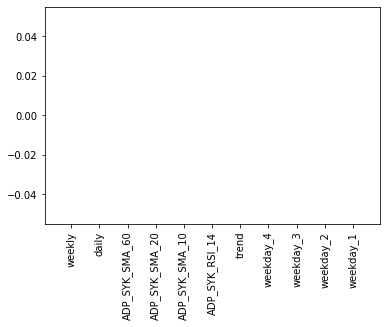

In [796]:
# feature importances 
importances = xgb_model.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

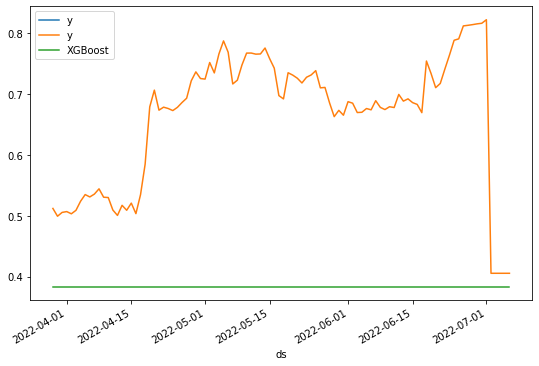

In [797]:
# visualisation
train_set.y['2022-07-28':].plot(figsize=(9, 6), legend=True)
test_set.y.plot(legend=True)
xgb_preds.plot(legend=True);

In [798]:
# evaluation
# mae and rmse
print(round(mean_absolute_error(test_set['y'], xgb_preds), 3))
print(round(mean_squared_error(test_set['y'], xgb_preds), 3))

# compute MAPE
y_true, y_pred = np.array(test_set['y']), np.array(xgb_preds)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(mape)

0.281
0.091
40.41600291729553


In [455]:
ratio_df[['Date', 'ADP_SYK', '5d_future_close', '5d_future_close_pct']].head(16)

,Date,ADP_SYK,5d_future_close,5d_future_close_pct
0,2022-02-23,0.771140,0.765541,NaN
1,2022-02-24,0.774126,0.765399,NaN
2,2022-02-25,0.766083,0.777620,NaN
3,2022-02-28,0.773484,0.819354,NaN
4,2022-03-01,0.767553,0.832825,NaN
5,2022-03-02,0.765541,0.836789,0.093068
6,2022-03-03,0.765399,0.844340,0.103137
7,2022-03-04,0.777620,0.837656,0.077204
8,2022-03-07,0.819354,0.843098,0.028978
9,2022-03-08,0.832825,0.835860,0.003644


In [187]:
ratio_df = sorted_df.iloc[:, :5]

In [451]:
# add price features
# the new column contains the %age change of each day compared to the prior 5 days
ratio_df['5d_close_pct'] = ratio_df['ADP_SYK'].pct_change(5)

In [453]:
ratio_df['5d_future_close'] = ratio_df['ADP_SYK'].shift(-5)

In [454]:
ratio_df['5d_future_close_pct'] = ratio_df['5d_future_close'].pct_change(5)

In [191]:
# add datetime features and concatenate with ratio_df
days_of_week = pd.get_dummies(ratio_df.index.dayofweek, prefix='weekday', drop_first=True)
ratio_df = pd.concat([ratio_df.reset_index(), days_of_week], axis=1, ignore_index=False)

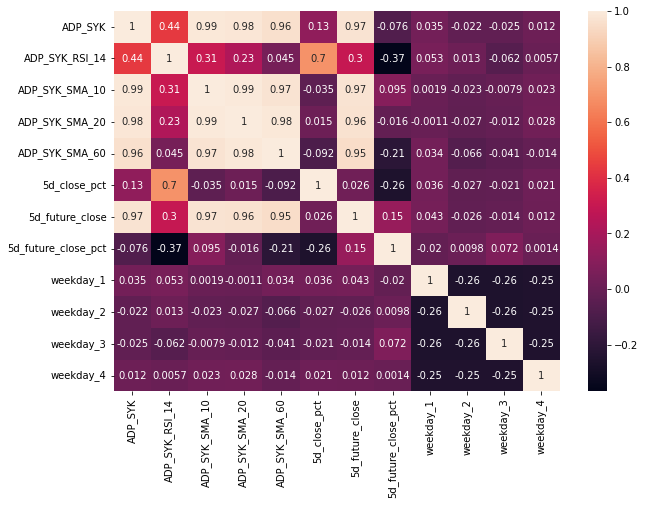

In [192]:
corr1 = ratio_df.corr()
dims = (10, 7)
fig, ax = plt.subplots(figsize=dims)
sns.heatmap(corr1, annot=True, fmt='.2g');

In [247]:
# extract features for modelling
feature_names = ['5d_close_pct', 'ADP_SYK_SMA_10', 'ADP_SYK_SMA_20', 'ADP_SYK_SMA_60', 'ADP_SYK_RSI_14', 
                 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4']
features = ratio_df[feature_names]
targets = ratio_df['5d_future_close_pct']

In [197]:
feature_target_df = pd.concat([ratio_df[feature_names], ratio_df['5d_future_close_pct']], axis=1)

In [250]:
# make train and test sets
#linear_features = sm.add_constant(features)
linear_features = features.fillna(features.median())
target_median = targets.median()
targets.fillna(target_median, inplace=True)

train_size = int(0.85 * targets.shape[0])
X_train = linear_features[:train_size]
y_train = targets[:train_size]
X_test = linear_features[train_size:]
y_test = targets[train_size:]

In [254]:
# build the XGBoost model
xgb_reg = XGBRegressor(booster='gbtree',
                       objective='reg:squarederror',
                       max_depth=3,
                       n_estimators=100,
                       learning_rate=0.1,
                       n_jobs=-1,
                       random_state=2)

In [255]:
# fit the model
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=2, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

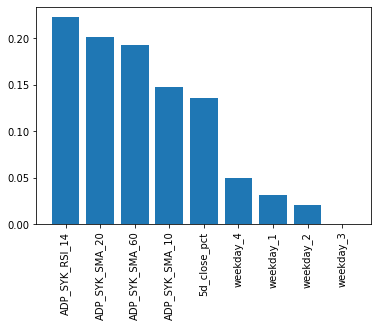

In [259]:
# check feature importances
importances = xgb_reg.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

In [278]:
# make a 5 day prediction
y_pred = pd.Series(xgb_reg.predict(X_test), name='XGBoost')
y_pred.index = ratio_df.Date[train_size:]

In [279]:
y_pred

Date
2022-07-28    0.023331
2022-07-29    0.023898
2022-08-01    0.019450
2022-08-02    0.018176
2022-08-03    0.013803
2022-08-04    0.019902
2022-08-05    0.022547
2022-08-08    0.028720
2022-08-09    0.003909
2022-08-10    0.015435
2022-08-11    0.023331
2022-08-12    0.024916
2022-08-15    0.023784
2022-08-16    0.023212
2022-08-17   -0.002251
2022-08-18   -0.006561
2022-08-19   -0.004613
2022-08-22   -0.005010
2022-08-23   -0.007034
Name: XGBoost, dtype: float32

### XGBoost - End

# Model test

DO NOT CHANGE !

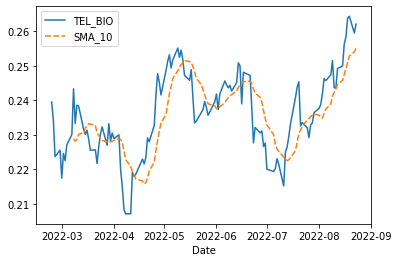

In [6]:
df = pd.read_csv('../../long_short_local/raw_data/cleaned_data.csv')
# convert 'Date' column to datetime values
df['Date'] = pd.to_datetime(df['Date'].str[:10])

test_df = df[['Date', 'TEL_BIO']]
sma10 = pd.DataFrame(ta.sma(test_df["TEL_BIO"], length=10))
tel_bio_df = pd.concat([test_df, sma10], axis=1, ignore_index=False)
tel_bio_df.set_index('Date', inplace=True)
sns.lineplot(data=tel_bio_df);

DO NOT CHANGE !

In [7]:
# convert 'Date' column to datetime values
df['Date'] = pd.to_datetime(df['Date'].str[:10])

AttributeError: Can only use .str accessor with string values!

In [ ]:
# split into 'train' and 'test' data
split_date = df['Date'][41]
df.set_index('Date', inplace=True)
train_df = df.loc[df.index <= split_date].copy()
test_df = df.loc[df.index > split_date].copy()

In [ ]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.weekofyear

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(train_df, label='number')

In [ ]:
X_test, y_test = create_features(test_df, label='number')

In [ ]:
# build first model
model = XGBRegressor(n_estimators=1000)

In [ ]:
model.fit()